# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we perform NA-MD using the NACs computed in [step3](../../8_step3_cp2k/2_xTB). After the dynamic is done, we will fit the data using a stretched-compressed exponential function. We only do the dynamics for the NACs computed for the system in the xTB framework. The reason is that doing the NA-MD for the other system we considered with DFT, the rutile-$TiO_2$ unit cell, is exactly the same as below and you just need to modify some parameters as is explained in the [README.md](README.md) file. 

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Defining the functions and variables](#def_fun_var)
4. [Run the dynamics](#run_dyn) 
5. [Fitting data](#fit_data)

### A. Learning objectives

* To be able to run the NA-MD using Libra
* To be able to compute the average NA-MD timescales

### B. Use cases

* [Run the dynamics](#run_dyn)
* [Fitting data](#fit_data)


### C. Functions

- `libra_py`
  - `data_conv`
  - `data_stat`
  - `data_outs`
  - `data_read`
  - `workflows`
    - `nbra`
      - [`step4`](#run_dyn)
        - [`namd_workflow`](#run_dyn)
  - `units`
    - `fs2au`
    


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library to read them. Import `numpy`, `scipy.sparse`, `data_conv`, `data_outs`, `data_stat`, `data_io`, `units`, and `step4` modules and also the `ann` for doing the NA-MD using artificial neural netwrok (we do not cover this in here). Also, `multiprocessing` library will be needed to simultaneously run the NA-MD in different batches.
The `scipy.optimize.curve_fit` will be used to fit the data and plot them using `matplotlib`.

In [1]:
import os
import sys
import math
import time
import glob 

import multiprocessing as mp
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from liblibra_core import *
import util.libutil as comn
from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.ann as ann

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The only files that we need are the NACs stored in `../../8_step3_cp2k/2_xTB/res-mixed-basis` folder.

## 3. Defining the functions and variables <a name="def_fun_var"></a>
[Back to TOC](#toc)

The helper functions are used in here. We will set the parameters in here. The list of all parameters are completely explained in the [README.md](README.md) file.

In [2]:
class tmp:
    pass


#obj = tmp()
#obj.basis_transform = CMATRIX(2,2)
#obj.basis_transform.identity()


def compute_model_nbra_direct_global(q, params, full_id):
    """   
    Read in the vibronic Hamiltonians along the trajectories    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the directory where the hdf5 file is located ]
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        
    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """

    timestep = params["timestep"]
    nadi = params["nstates"]

    #=========== Basis transform, if available =====
    basis_transform = CMATRIX(nadi, nadi)
    basis_transform.identity()

    #========= Time-overlap matrices ===================
    time_overlap_adi = CMATRIX(nadi, nadi)
    time_overlap_adi.identity()

    obj = tmp()
    obj.ham_adi = params["HADI"][timestep]
    obj.nac_adi = params["NAC"][timestep]
    obj.hvib_adi = params["HVIB"][timestep]
    obj.basis_transform = basis_transform
    obj.time_overlap_adi = params["ST"][timestep]

    return obj




def compute_model(q, params, full_id):
    model = params["model"]
    res = None

    if model==1:
        pass
    elif model==2:
        #res = ham.compute_model_nbra_2state_direct(q, params, full_id)        
        res = compute_model_nbra_direct_global(q, params, full_id)
    elif model==3:
        res = ann.compute_model_nbra_ann(q, params, full_id)
        #res.time_overlap_adi = ST[ params["timestep"] ]

    return res



#if __name__ == '__main__':

def run_dynamics(case, what):



    if case=="direct" and what in [0, 2] :
        os.system("mkdir namd_regular")
    elif case=="ann" and what in [0, 2]:
        os.system("mkdir namd_ann")


    nthreads = 8
    methods = {0:"FSSH", 1:"IDA", 2:"mSDM", 3:"DISH", 21:"mSDM2", 31:"DISH2" }
    init_states = [10]
    tsh_methods = [0,1]#, 1]
    batches = list(range(4))





    #================== SET UP THE DYNAMICS AND DISTRIBUTED COMPUTING SCHEME  ===============                      

    rnd = Random()

    rates = None
    gaps = None

    params_common = { "path_to_res_files": os.getcwd()+'/../../8_step3_cp2k/2_xTB/res-mixed-basis', "is_sparse": True,
                      "Hvib_re_prefix": 'Hvib_sd_', "Hvib_re_suffix": '_re',
                      "Hvib_im_prefix": 'Hvib_sd_', "Hvib_im_suffix": '_im', "istep": 1,
                      "St_re_prefix": 'St_sd_', "St_re_suffix": '_re',
                      "nsteps": 147, "dt":0.5*units.fs2au, "is_parallel": True,
                      "ntraj":100, "x0":[-4.0], "p0":[4.0], "masses":[2000.0], "k":[0.01],
                      "nstates":5, "istate":[1, 0],
                      "which_adi_states":range(5), "which_dia_states":range(5),
                      "rep_ham":1, "tsh_method":0, "force_method":0, "nac_update_method":0,
                      "hop_acceptance_algo":31, "momenta_rescaling_algo":0,
                      "time_overlap_method":1, "mem_output_level":-1,  "txt_output_level":-1, "txt2_output_level":3,
                      "properties_to_save": ['timestep', 'time', 'SH_pop', 'SH_pop_raw'],
                      "state_tracking_algo":2, "convergence":0,  "max_number_attempts":100,
                      "do_phase_correction":1,
                      "min_probability_reordering":0.01, "decoherence_algo":0, "Temperature": 300.0
                    }


    #=========================== DIRECT ==============================

    if case == "direct":

        dyn_params = dict(params_common)
        dyn_params.update({ "dir_prefix":"namd_regular" })
        ham_rep, is_nbra = 1, 1


        if what in [0, 2]:
            model_params_direct = {"model":2, "filename":None}
            HADI, HVIB, NAC, ST, nstates = data_read.get_all_data(params_common) #["nsteps"],  istep=0, nstates = 5)
            params_common["nstates"] = nstates
            dyn_params["nstates"] = nstates
            model_params_direct["nstates"] = nstates
            model_params_direct["istep"] = params_common["istep"]
            model_params_direct["HVIB"] = HVIB
            model_params_direct["HADI"] = HADI
            model_params_direct["NAC"] = NAC
            model_params_direct["ST"] = ST
            print(model_params_direct, 'Done with reading the files... Going to step4.')

            step4.namd_workflow(dyn_params, compute_model, model_params_direct, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        #if what in [1, 2]:
        #    plotting.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Direct NA-MD", txt_type=1)

    #=========================== ANN =================================
    elif case == "ann":

        dyn_params = dict(params_common)
        dyn_params.update({ "dir_prefix":"namd_ann" })
        ham_rep, is_nbra = 1, 1

        if what in [0, 2]:

            model_params_ann = {"model":3, "nstates":5, "filename":None, "istep":0, "dt":1.0*units.fs2au, "timestep":0 }
            ann.load_ann_and_parameters(model_params_ann, nstates=5, prefix="./")
            print(model_params_ann)

            step4.namd_workflow(dyn_params, compute_model, model_params_ann, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        #if what in [1, 2]:
        #    plotting.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Ann NA-MD", txt_type=1)


## 4. Run the dynamics <a name="run_dyn"></a>
[Back to TOC](#toc)

Run the dynamics using this line:



In [3]:
run_dynamics("direct", 2)

Reading the data of step 1
Reading the data of step 2
Reading the data of step 3
Reading the data of step 4
Reading the data of step 5
Reading the data of step 6
Reading the data of step 7
Reading the data of step 8
Reading the data of step 9
Reading the data of step 10
Reading the data of step 11
Reading the data of step 12
Reading the data of step 13
Reading the data of step 14
Reading the data of step 15
Reading the data of step 16
Reading the data of step 17
Reading the data of step 18
Reading the data of step 19
Reading the data of step 20
Reading the data of step 21
Reading the data of step 22
Reading the data of step 23
Reading the data of step 24
Reading the data of step 25
Reading the data of step 26
Reading the data of step 27
Reading the data of step 28
Reading the data of step 29
Reading the data of step 30
Reading the data of step 31
Reading the data of step 32
Reading the data of step 33
Reading the data of step 34
Reading the data of step 35
Reading the data of step 36
R

In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'SH_pop', 'SH_pop_raw'])
In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'SH_pop', 'SH_pop_raw'])
 step= 0

 step= 0In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave

## 5. Fitting data <a name="fit_data"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `SH_pop.txt` files, using `np.loadtxt` and start fitting them to a stretched-compressed exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^\beta)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.8$. The error bars are computed using the following formula:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.8$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In the above, we have only considered, FSSH and IDA ad for simplicity, we will consider the decay dynamics of the hot state which is the 10th state. Also, please note that this is just an example and we want to show how the workflow is. So, we consider even lower $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.

<IPython.core.display.Javascript object>


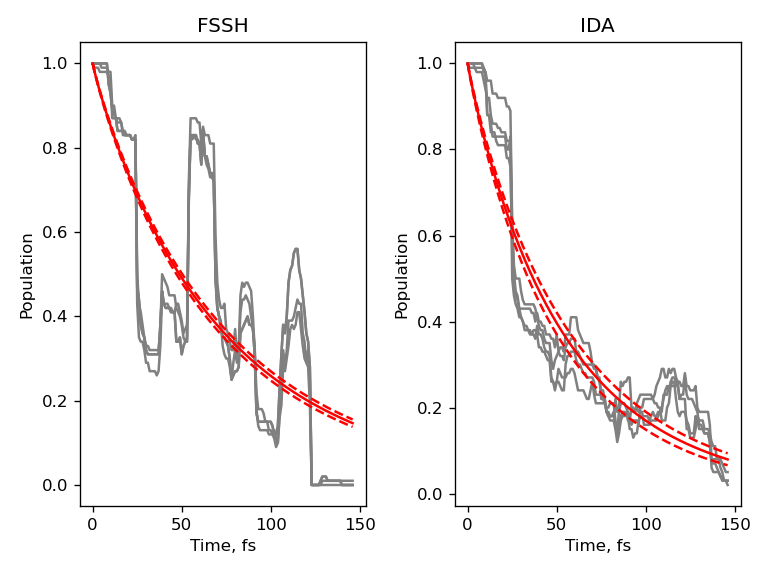

------------FSSH----------
./namd_regular/_start_s5_FSSH_batch0
tau: 0.48445738225756857  beta: 3.257509945546818  R2: -inf
./namd_regular/_start_s5_FSSH_batch1
tau: 0.48445738225756857  beta: 3.257509945546818  R2: -inf
./namd_regular/_start_s10_FSSH_batch1
tau: 72.33491681261773  beta: 0.892164731104359  R2: 0.6054265026785073
./namd_regular/_start_s10_FSSH_batch0
tau: 72.33491681261773  beta: 0.892164731104359  R2: 0.6054265026785073
./namd_regular/_start_s10_FSSH_batch2
tau: 75.76457491835033  beta: 0.9859143655080296  R2: 0.6266491148429447
./namd_regular/_start_s10_FSSH_batch3
tau: 68.74603312260372  beta: 0.9396996810955937  R2: 0.640784484990256
The timescales: 72.29511041654737+-2.4321135397232254 average over 4 samples
------------IDA----------
./namd_regular/_start_s10_IDA_batch1
tau: 60.68207712225786  beta: 0.9538276272704304  R2: 0.8692085704047336
./namd_regular/_start_s10_IDA_batch0
tau: 51.78959561576633  beta: 0.9232889851981259  R2: 0.8905777272122083
./namd_regular/

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


tau: 54.87326661911055  beta: 0.9423814060242778  R2: 0.9290803851662142
The timescales: 54.330826146412676+-3.9818160763953223 average over 4 samples


In [14]:
%matplotlib notebook
plt.figure()
def stretched_compressed(t, tau, beta):
    return np.exp( -np.power(( t/tau ),beta) )

for c, scheme in enumerate(['FSSH', 'IDA']):
    print(F'------------{scheme}----------')
    plt.subplot(1,2,c+1)
    folders = glob.glob(F'./namd_regular/*{scheme}*', recursive = True)
    taus = []
    betas = []
    for folder in folders:
        print(folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        if r_squared>0.5:
            taus.append(tau)
            betas.append(beta)
            plt.plot(md_time, sh_pop_hot_state, color='gray')
    ave_tau = np.average(np.array(taus))
    ave_beta = np.average(np.array(betas))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus)
    s = np.std(np.array(taus))
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales: {ave_tau}+-{error_bar} average over {len(taus)} samples')
    
    # Plot average fit
    
    plt.plot(md_time, stretched_compressed(md_time, ave_tau-error_bar, ave_beta), ls='--', color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau,           ave_beta), ls='-',  color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau+error_bar, ave_beta), ls='--', color='red')
    
    plt.title(scheme)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.tight_layout()
        
        